In [104]:
from fn_basic import readFiles

import os, mne
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from statannotations.Annotator import Annotator

In [105]:
def readPSDFiles(exp_folder,psd_folder):
    dir_inprogress = os.path.join(psd_folder,exp_folder)
    _, b_names = readFiles(dir_inprogress,".xlsx")

    condition = [None]*len(b_names)
    for i in range(len(b_names)):
        condition[i] = b_names[i].split("_psd_", 1)
    
    return [dir_inprogress,b_names,condition]

def pairedTtest(df_psd):
    conditions = df_psd['Condition'].unique()
    bands = df_psd['Frequency band'].unique()
    regions = df_psd.drop(columns=['Subject','Frequency band','Condition']).columns.to_numpy()
    df_pvals = pd.DataFrame(index=regions, columns=bands)

    for band in bands:
        df_psd_band = df_psd[df_psd['Frequency band'] == band]
        df_psd_band_cond1 = df_psd_band[df_psd_band['Condition'] == conditions[0]]\
                                .drop(columns=['Subject','Frequency band','Condition'])
        df_psd_band_cond2 = df_psd_band[df_psd_band['Condition'] == conditions[1]]\
                                .drop(columns=['Subject','Frequency band','Condition'])
        for region in df_psd_band_cond1.columns:
            _,df_pvals[band][region] = stats.ttest_rel(df_psd_band_cond1[region], df_psd_band_cond2[region])

        sign_idx = df_pvals.index[df_pvals[band]<=0.05].to_numpy()
        sign_pvals = df_pvals[df_pvals[band]<=0.05][band].to_numpy()
        if len(sign_idx) != 0:
            print('Significant changes of',band,'are:')
        for i in range(len(sign_idx)):
            print(sign_idx[i],'with p-value of',sign_pvals[i])
    
    return df_pvals


In [106]:
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')
exp_folder_1 = r"Eyes Closed\Baseline"
exp_folder_2 = r"Eyes Closed\6 weeks"

psd_reg_folder = r"Results\PSD\regions"
psd_ch_folder = r"Results\PSD\channels"

[dir_inprogress_reg_1,b_names_reg_1,condition_reg_1] = readPSDFiles(exp_folder_1,psd_reg_folder)
[dir_inprogress_reg_2,b_names_reg_2,condition_reg_2] = readPSDFiles(exp_folder_2,psd_reg_folder)

[dir_inprogress_ch_1,b_names_ch_1,condition_ch_1] = readPSDFiles(exp_folder_1,psd_ch_folder)
[dir_inprogress_ch_2,b_names_ch_2,condition_ch_2] = readPSDFiles(exp_folder_2,psd_ch_folder)

clean_folder = r"Data\Clean"
dir_inprogress_epo = os.path.join(clean_folder,exp_folder_1)
_, subject_names = readFiles(dir_inprogress_epo,"_clean-epo.fif")
epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress_epo,subject_names[0]))

Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 26
Reading c:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\Data\Clean\Eyes Closed\Baseline\OKTOS_0001_00A_EC_clean-epo.fif ...
    Read a total of 1 projection items:
        EOG-eeg--0.200-0.200-PCA-01 (1 x 32) active
    Found the data of interest:
        t =       0.00 ...    4999.02 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
52 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [107]:
df_psd_reg = pd.DataFrame()
for i in range(len(b_names_reg_1)):
    globals()[b_names_reg_1[i]] = pd.read_excel('{}\{}.xlsx'.format(dir_inprogress_reg_1,b_names_reg_1[i]))\
                            .assign(**{'Frequency band': condition_reg_1[i][1],'Condition': condition_reg_1[i][0]})
    globals()[b_names_reg_2[i]] = pd.read_excel('{}\{}.xlsx'.format(dir_inprogress_reg_2,b_names_reg_2[i]))\
                            .assign(**{'Frequency band': condition_reg_2[i][1],'Condition': condition_reg_2[i][0]})

    globals()["df_psdreg_"+str(i)] = pd.concat([globals()[b_names_reg_1[i]],globals()[b_names_reg_2[i]]])
    df_psd_reg = pd.concat([df_psd_reg,globals()["df_psdreg_"+str(i)]])

df_reg_pvals = pairedTtest(df_psd_reg)
try:
    os.makedirs(os.path.join(psd_reg_folder,''))
except FileExistsError:
    pass
df_reg_pvals.to_excel(r"Results\PSD\regions\p-values_{}-{}.xlsx".format(condition_reg_1[1][0],condition_reg_2[1][0]))

df_psd_ch = pd.DataFrame()
for i in range(len(b_names_ch_1)):
    globals()[b_names_ch_1[i]] = pd.read_excel('{}\{}.xlsx'.format(dir_inprogress_ch_1,b_names_ch_1[i]))\
                            .assign(**{'Frequency band': condition_ch_1[i][1],'Condition': condition_ch_1[i][0]})
    globals()[b_names_ch_2[i]] = pd.read_excel('{}\{}.xlsx'.format(dir_inprogress_ch_2,b_names_ch_2[i]))\
                            .assign(**{'Frequency band': condition_ch_2[i][1],'Condition': condition_ch_2[i][0]})

    globals()["df_psdch_"+str(i)] = pd.concat([globals()[b_names_ch_1[i]],globals()[b_names_ch_2[i]]])
    df_psd_ch = pd.concat([df_psd_ch,globals()["df_psdch_"+str(i)]])

df_ch_pvals = pairedTtest(df_psd_ch)



try:
    os.makedirs(os.path.join(psd_ch_folder,''))
except FileExistsError:
    pass
df_ch_pvals.to_excel(r"Results\PSD\channels\p-values_{}-{}.xlsx".format(condition_ch_1[1][0],condition_ch_2[1][0]))

Significant changes of Low-Beta are:
Frontal with p-value of 0.04331348561142242
Significant changes of Alpha are:
Pz with p-value of 0.02301858037415522
Significant changes of Delta are:
P8 with p-value of 0.049050631029278036
T8 with p-value of 0.02538714188019807
Significant changes of High-Beta are:
FC1 with p-value of 0.030061047108077027
Significant changes of Low-Beta are:
FC1 with p-value of 0.007626680747325017
Pz with p-value of 0.03366878147690126


['EC_00' 'EC_06']
Plotting EC_00 and EC_06 for Alpha
Plotting EC_00 and EC_06 for Delta
Plotting EC_00 and EC_06 for High-Beta
Plotting EC_00 and EC_06 for Low-Beta
Plotting EC_00 and EC_06 for Theta


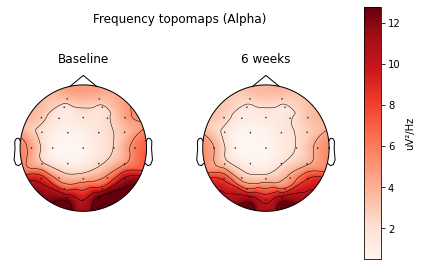

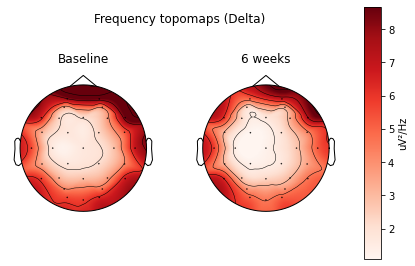

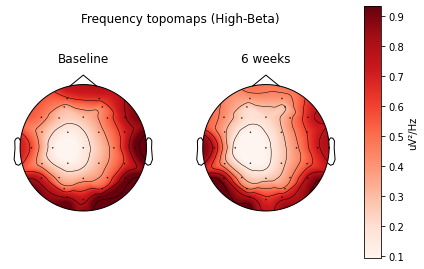

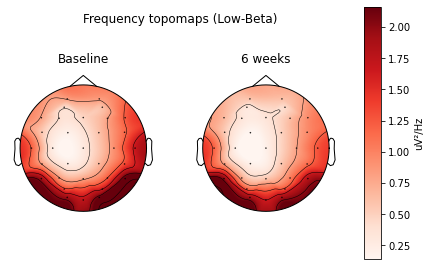

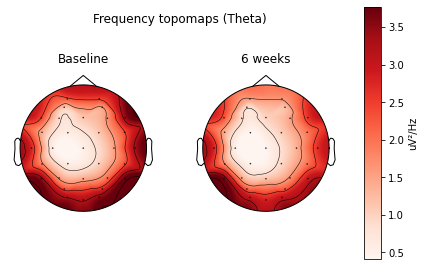

In [6]:
def plotPSDTopoComparison(df_psd_ch,b_name,condition_titles,fig_title):
    conditions = df_psd_ch['Condition'].unique()
    df_psd_ch_band = df_psd_ch[df_psd_ch['Frequency band'] == b_name].drop(columns=['Frequency band','Subject'])
    ar_psd_meanch_band_cond1 = df_psd_ch_band[df_psd_ch_band['Condition'] == conditions[0]]\
                                    .drop(columns=['Condition']).to_numpy().mean(axis=0)
    ar_psd_meanch_band_cond2 = df_psd_ch_band[df_psd_ch_band['Condition'] == conditions[1]]\
                                    .drop(columns=['Condition']).to_numpy().mean(axis=0)

    print('Plotting',conditions[0],'and',conditions[1],'for',b_name)

    vmin = min([min(ar_psd_meanch_band_cond1),min(ar_psd_meanch_band_cond2)])
    vmax = max([max(ar_psd_meanch_band_cond1),max(ar_psd_meanch_band_cond2)])
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
    fig.suptitle(fig_title,x=0.525)
    im,cm = mne.viz.plot_topomap(ar_psd_meanch_band_cond1,epochs.info,axes=ax1,vmin=vmin,vmax=vmax,show=False)
    im,cm = mne.viz.plot_topomap(ar_psd_meanch_band_cond2,epochs.info,axes=ax2,vmin=vmin,vmax=vmax,show=False)
    ax1.set_title(condition_titles[0])
    ax2.set_title(condition_titles[1])
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.125
    ax_y_height = 0.875
    
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_ylabel('uV\u00b2/Hz')

print(df_psd_ch['Condition'].unique())

for b_name in (df_psd_ch['Frequency band'].unique()):
    plotPSDTopoComparison(df_psd_ch,b_name,['Baseline','6 weeks'],'Frequency topomaps ({})'.format(b_name))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Theta_EC_00 vs. Theta_EC_06: t-test paired samples, P_val:2.226e-01 t=1.251e+00
Delta_EC_00 vs. Delta_EC_06: t-test paired samples, P_val:3.120e-01 t=1.032e+00
Alpha_EC_00 vs. Alpha_EC_06: t-test paired samples, P_val:1.874e-01 t=1.355e+00
Low-Beta_EC_00 vs. Low-Beta_EC_06: t-test paired samples, P_val:4.331e-02 t=2.129e+00
High-Beta_EC_00 vs. High-Beta_EC_06: t-test paired samples, P_val:9.444e-02 t=1.738e+00


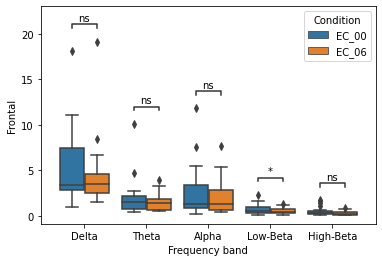

In [135]:
conditions = df_psd_reg['Condition'].unique()
b_order = ['Delta','Theta','Alpha','Low-Beta','High-Beta']
y = 'Frontal'
x='Frequency band'
hue='Condition'

plt.figure()
ax = sns.boxplot(x=x, y=y, hue=hue, order=b_order, data=df_psd_reg)
            
pairs=[((b_order[0],conditions[0]),(b_order[0],conditions[1])),
       ((b_order[1],conditions[0]),(b_order[1],conditions[1])),
       ((b_order[2],conditions[0]),(b_order[2],conditions[1])),
       ((b_order[3],conditions[0]),(b_order[3],conditions[1])),
       ((b_order[4],conditions[0]),(b_order[4],conditions[1]))]

annotator = Annotator(ax,pairs=pairs,data=df_psd_reg, x=x, y=y,
                      hue=hue,plot="boxplot",order=b_order)\
            .configure(test='t-test_paired', text_format='star', loc='inside')\
            .apply_and_annotate()


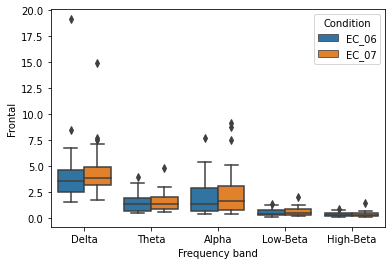

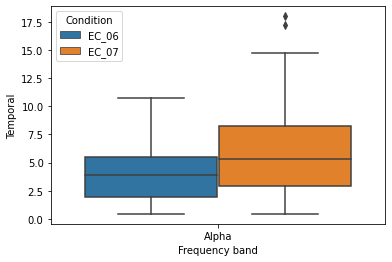

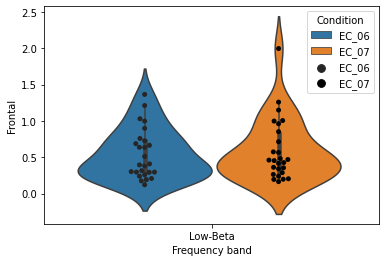

In [93]:
#sns.set()
#sns.set_theme(style="darkgrid")
plt.figure()
ax = sns.boxplot(x='Frequency band', y='Frontal',
            hue='Condition',order=['Delta','Theta','Alpha','Low-Beta','High-Beta'],
            data=df_psd_reg)

plt.figure()
ax = sns.boxplot(x='Frequency band', y='Temporal',
                 hue='Condition',
                 data=df_psd_reg[df_psd_reg['Frequency band'] == 'Alpha'])

plt.figure()
ax = sns.violinplot(x='Frequency band', y='Frontal',
                 hue='Condition',
                 data=df_psd_reg[df_psd_reg['Frequency band'] == 'Low-Beta'])
ax = sns.swarmplot(x='Frequency band', y='Frontal',
                   hue='Condition', color='0.01', dodge=True,
                   data=df_psd_reg[df_psd_reg['Frequency band'] == 'Low-Beta'])